In [2]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.applications.mobilenet
import os
import PIL
import cv2
import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

IMG_SAVE_PATH_Test = 'Dataset_new/CTSCAN/test'

# Get a list of folder names in the directory
folders = [name for name in os.listdir(IMG_SAVE_PATH_Test) if os.path.isdir(os.path.join(IMG_SAVE_PATH_Test, name))]

# Create a dictionary with index as key and folder name as value
folders_dict = {folder: index for index, folder in enumerate(folders)}
folders_dict

Str_to_Int = folders_dict

NUM_CLASSES = 2
def str_to_Int_mapper(val):
    return Str_to_Int[val]



def preprocess(IMG_SAVE_PATH):
    dataset = []
    for directory in os.listdir(IMG_SAVE_PATH):
        path = os.path.join(IMG_SAVE_PATH, directory)
        for image in os.listdir(path):
            new_path = os.path.join(path, image)
            try:
                imgpath=PIL.Image.open(new_path)
                imgpath=imgpath.convert('RGB')
                img = np.asarray(imgpath)
                img = cv2.resize(img, (331,331))
                img=img/255.
                dataset.append([img, directory])
            except FileNotFoundError:
                print('Image file not found. Skipping...')
    return dataset
traindata=preprocess(IMG_SAVE_PATH_Test)

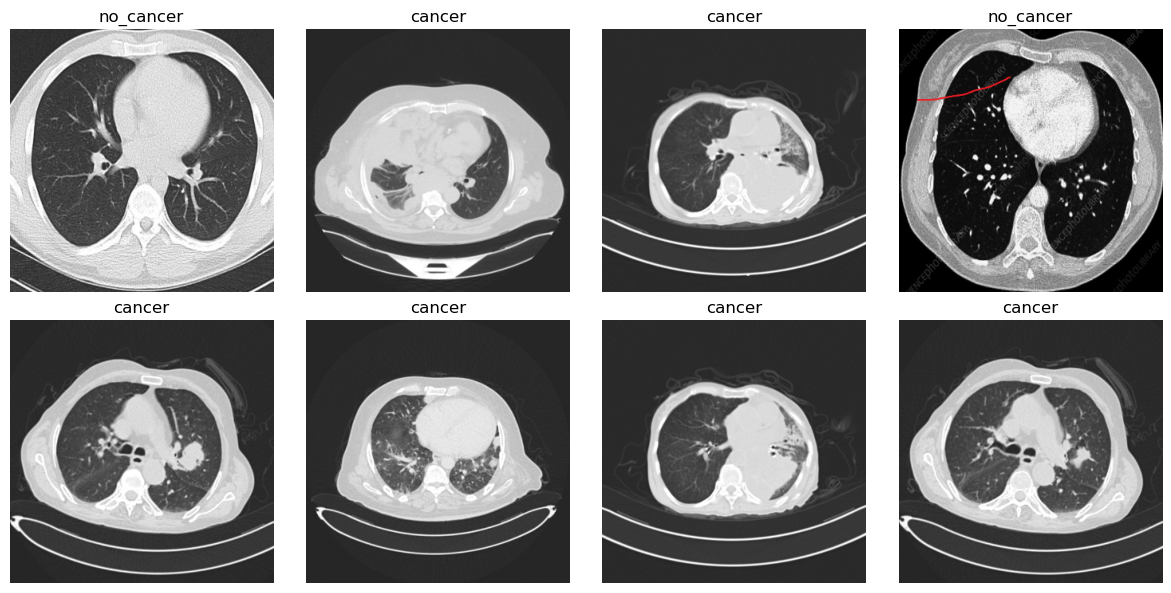

In [3]:
xtest, labelstest = zip(*traindata)

import matplotlib.pyplot as plt
import random

# Randomly select 8 indices from the dataset
indices = random.sample(range(len(xtest)), 8)

# Set up the plot grid
plt.figure(figsize=(12, 6))

# Loop through the selected indices
for i, idx in enumerate(indices):
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
    plt.imshow(xtest[idx])  # Assuming data[idx] is an image
    plt.title(labelstest[idx])
    plt.axis('off')

# Display the plot
plt.tight_layout()
plt.show()


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model

# Custom CNN model definition
def create_custom_cnn(input_shape=(331, 331, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3))(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(32, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)  # Flatten to create a 1D vector
    custom_cnn_model = Model(inputs, x)
    
    return custom_cnn_model

# Base model (InceptionResNetV2) definition
def create_combined_model(num_classes=2, cnn_input_shape=(331, 331, 3), inception_input_shape=(331, 331, 3)):
    # Custom CNN model
    custom_cnn = create_custom_cnn(input_shape=cnn_input_shape)
    
    # Pretrained InceptionResNetV2 (without top layers)
    base_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                                                         weights='imagenet',
                                                         input_shape=inception_input_shape)
    base_model.trainable = False  # Freeze InceptionResNetV2 layers
    
    # Flatten the output of the base model (InceptionResNetV2)
    inception_output = Flatten()(base_model.output)
    
    # Concatenate the output of custom CNN and InceptionResNetV2
    concatenated = Concatenate()([custom_cnn.output, inception_output])
    
    # Add dense layers after concatenation
    x = Dense(512, activation='relu')(concatenated)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    
    # Output layer (adjust the output for the number of classes)
    output = Dense(num_classes, activation='softmax')(x)
    
    # Create the final model
    model = Model(inputs=[custom_cnn.input, base_model.input], outputs=output)
    
    return model

# Instantiate the model
model = create_combined_model(num_classes=2)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.load_weights('CTSCANMODEL.h5')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 331, 331, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 165, 165, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 165, 165, 32)      │              96 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 165, 165, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 163, 163, 32)      │           9,216 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 163, 163, 32)      │              96 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_4 (Activation)     │ (None, 163, 163, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 163, 163, 64)      │          18,432 │ activation_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 163, 163, 64)      │             192 │ conv2d_5[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_5 (Activation)     │ (None, 163, 163, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 81, 81, 64)        │               0 │ activation_5[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 81, 81, 80)        │           5,120 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 81, 81, 80)        │             240 │ conv2d_6[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_6 (Activation)     │ (None, 81, 81, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 79, 79, 192)       │         138,24

 Total params: 168,071,490 (641.14 MB)

 Trainable params: 113,734,754 (433.86 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [15]:
temp1 = list(map(str_to_Int_mapper, labelstest))
xtest=np.array(xtest)
ytest = tensorflow.keras.utils.to_categorical(temp1)
Y=np.array(ytest)



In [18]:
Y_pred = model.predict([xtest, xtest])


8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step


In [19]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_pred_max_prob = np.max(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y,axis = 1) 

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

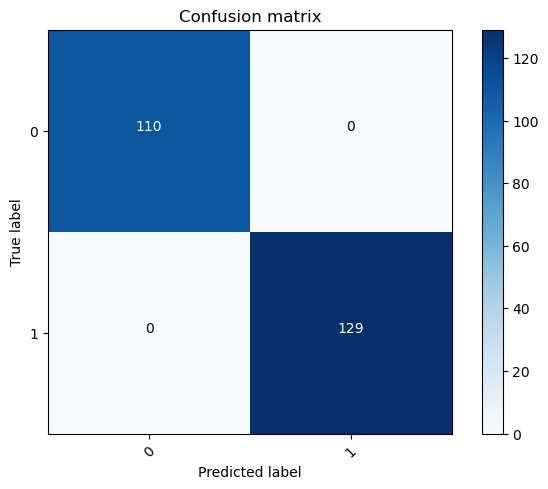

In [21]:
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.metrics import confusion_matrix
import itertools
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming Y_true and Y_pred_classes are defined
# Y_true: Actual labels
# Y_pred_classes: Predicted labels

# Compute accuracy
accuracy = accuracy_score(Y_true, Y_pred_classes)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
print("Precision:", precision)

# Compute recall
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
print("Recall:", recall)

# Compute F1-score
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print("F1 Score:", f1)


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
